## Домашка 6

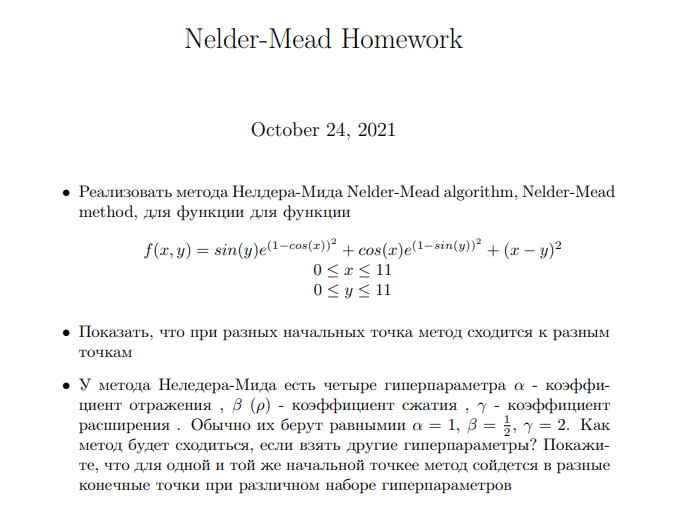

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from matplotlib.ticker import FuncFormatter

import seaborn as sns
import cvxpy as cvx

sns.set(font_scale=1.5, palette='Set2')
sns.set_style('whitegrid')

Для начала построим просто график искомой функции на требуемом множестве, чтобы понять, как она выглядит

In [2]:
def f(ps):
    # ps - точки, на которых нужно построить функцию, причем
    # ps.shape[-1] = 2, т.е. последняя размерность отвечает за координату у точки
    X = np.array([x]) if np.isscalar(x) else ps[..., 0]
    Y = np.array([y]) if np.isscalar(x) else ps[..., 1]
    A = np.sin(Y)
    B = np.cos(X)
    res = A * np.exp((1-B)**2) + B * np.exp((1-A)**2) + (X - Y)**2
    return res[0] if np.isscalar(x) and np.isscalar(y) else res

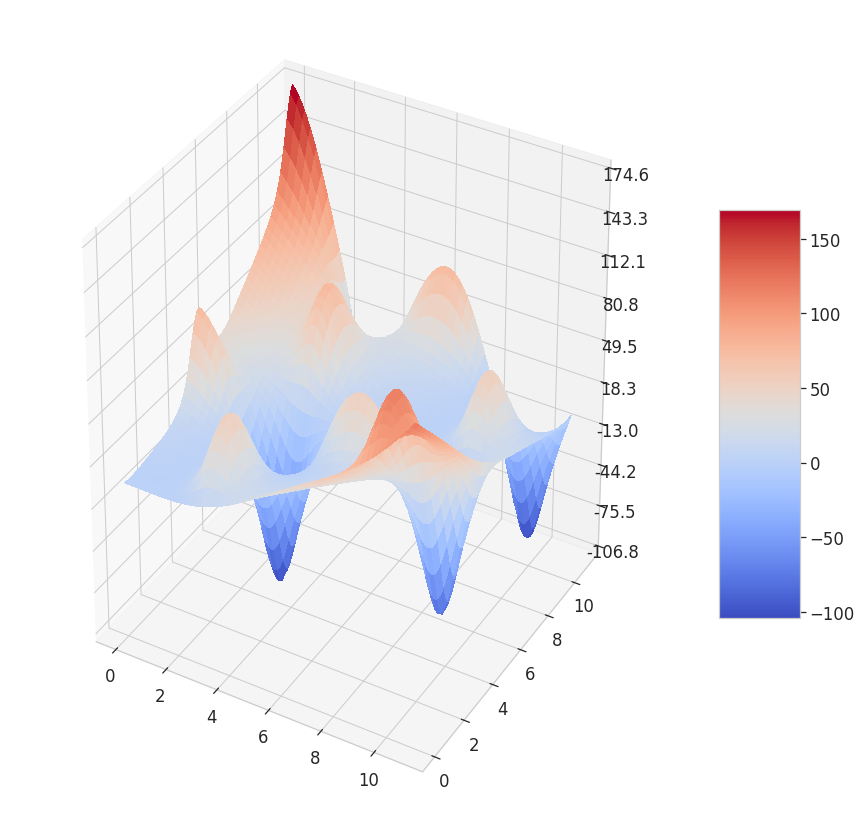

In [3]:
x = np.linspace(0, 11, 1001)
y = np.linspace(0, 11, 1001)
x, y = np.meshgrid(x, y)
ps = np.stack((x, y), axis=-1)
z = f(ps)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(15, 15))
surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
# ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically

def z_fmt(x, y):
    return f'{x:.01f}'

ax.zaxis.set_major_formatter(FuncFormatter(z_fmt))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

Как видим, график "колбасит": он имеет множество локальных экстремумов - как минимумов, так и максимумов, значит от места старта алгоритма может сильно зависеть то, какой результат мы получим

### 1. Реализация метода Нелдера-Мида

In [53]:
def NelderMead(func, start_points, alpha=1, beta=0.5, gamma=2, delta=0.5, eps=1e-5):
    '''
    Реализация метода Нелдера-Мида для поиска минимума функции
    :param func: функция, для которой ищется минимум. Должна уметь принимать np.array векторов, на
        которых вычисляется функция, т.е.  func([x_1, x_2 ... x_n]) -> [func(x_1), func(x_2), ... func(x_n)]
    :param start_points: исходные n+1 точка, с которых начинается работа алгоритма
    :param alpha: гиперпараметр метода альфа
    :param beta:  гиперпараметр метода бета
    :param delta: гиперпараметр метода гамма
    :param eps: критерий остановки - стандартное отклонение значений f на точках текущей итерации 
        не превышает eps 
    :returns: находит точку минимума выпуклой функции
    '''
    x = start_points
    sequence = x[np.newaxis, :]
    fx = f(x)

    # массив n+1xn+1, содержащий искомые точки и значение функций в них
    # с ним и будем работать
    xf = np.hstack((x, fx[:, np.newaxis]))  
    xf = xf[xf[:, -1].argsort()]

    while True:
        c = xf[:-1, :-1].mean(axis=0)
        x_r = (1+alpha) * c - alpha * xf[-1, :-1]
        f_r = func(x_r[np.newaxis, :])

        check = (f_r >= xf[-2, -1])
        subst = np.append(x_r, f_r)

        if f_r < xf[0, -1]:
            x_e = (1 - gamma)*c + gamma*x_r
            f_e = func(x_e[np.newaxis, :])
            if f_e < f_r:
                subst = np.append(x_e, f_e)

        if not check:
            xf[-1] = subst
        else:
            if f_r < xf[-1, -1]:
                xf[-1] = subst

            x_c = beta * xf[-1, :-1] + (1 - beta) * c
            f_c = f(x_c)
            if f_c < xf[-1, -1]:
                xf[-1, :-1], xf[-1, -1] = x_c, f_c
            else:
                x = xf[:, :-1]
                x = (1-delta)*xf[0, :-1] + delta * x

                fx = f(x)
                xf = np.hstack((x, fx[:, np.newaxis]))
        
        # Поддерживаем отсортированными перед каждым следующим циклом
        xf = xf[xf[:, -1].argsort()]
        
        sequence = np.append(sequence, xf[np.newaxis, :, :-1], axis=0)
        if np.std(xf[:, -1]) < eps:
            return xf[0, :-1], sequence

In [54]:
start = np.array([(0.1, 0.1), (0.3, 0.7), (0.7, 0.3)])
results, sequences = NelderMead(f, start)

results

array([0.90310138, 0.66633943])

### 2. Берем разные точки и показываем, что сходится к разным значениям

In [55]:
starts = np.array([[(0.1, 0.1), (0.3, 0.7), (0.7, 0.3)],
                   [(10.1, 10.1), (10.3, 0.7), (10.7, 10.3)],
                   [(5.1, 5.1), (5.3, 0.7), (5.7, 5.3)],
                   [(2.2, 3.3), (8.1, 4.8), (4.3, 10.7)]])

results, sequences = zip(*[NelderMead(f, start) for start in starts])
results = np.array(results)
results_f = f(results)

In [56]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PolyCollection
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


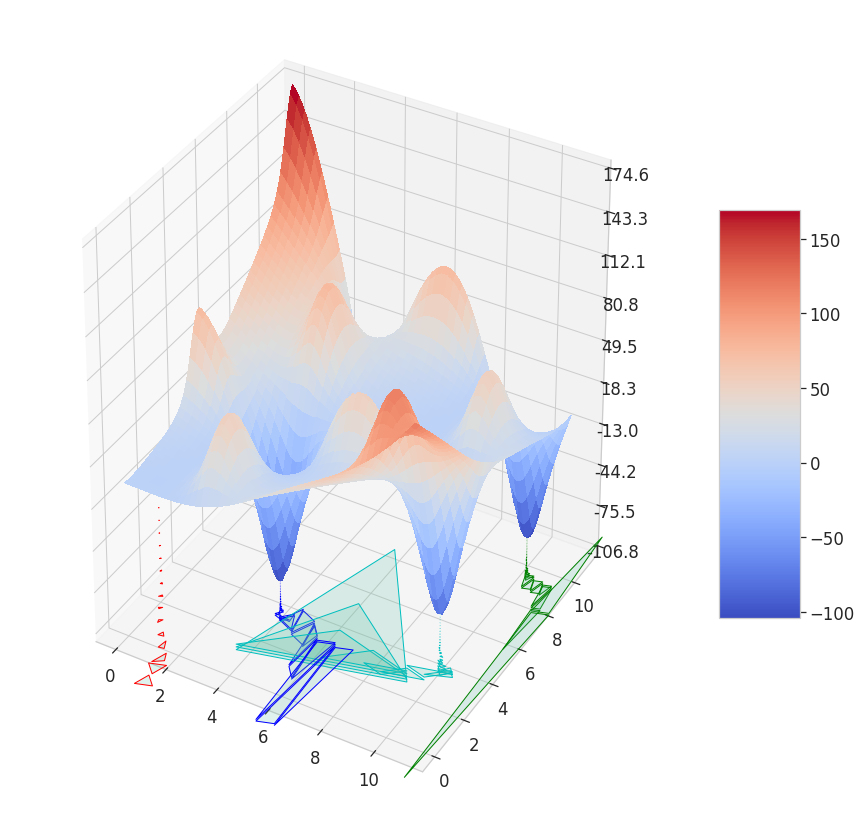

In [57]:
x = np.linspace(0, 11, 1001)
y = np.linspace(0, 11, 1001)
x, y = np.meshgrid(x, y)
ps = np.stack((x, y), axis=-1)
z = f(ps)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(15, 15))
surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

for sequence, color in zip(sequences, ['r', 'g', 'b', 'c']):
    best_z = f(sequence[-1][0])
    zs = np.linspace(-150, best_z, sequence.shape[0])
    for triangle, z in zip(sequence, zs):
        triangle = np.hstack((triangle, np.full(shape=(3, 1),fill_value=z)))
        ax.add_collection3d(Poly3DCollection(triangle, edgecolors=color, linewidths=1, alpha=0.2))

# ax.view_init(-90, 0)

ax.zaxis.set_major_locator(LinearLocator(10))
def z_fmt(x, y):
    return f'{x:.01f}'
ax.zaxis.set_major_formatter(FuncFormatter(z_fmt))
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [58]:
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

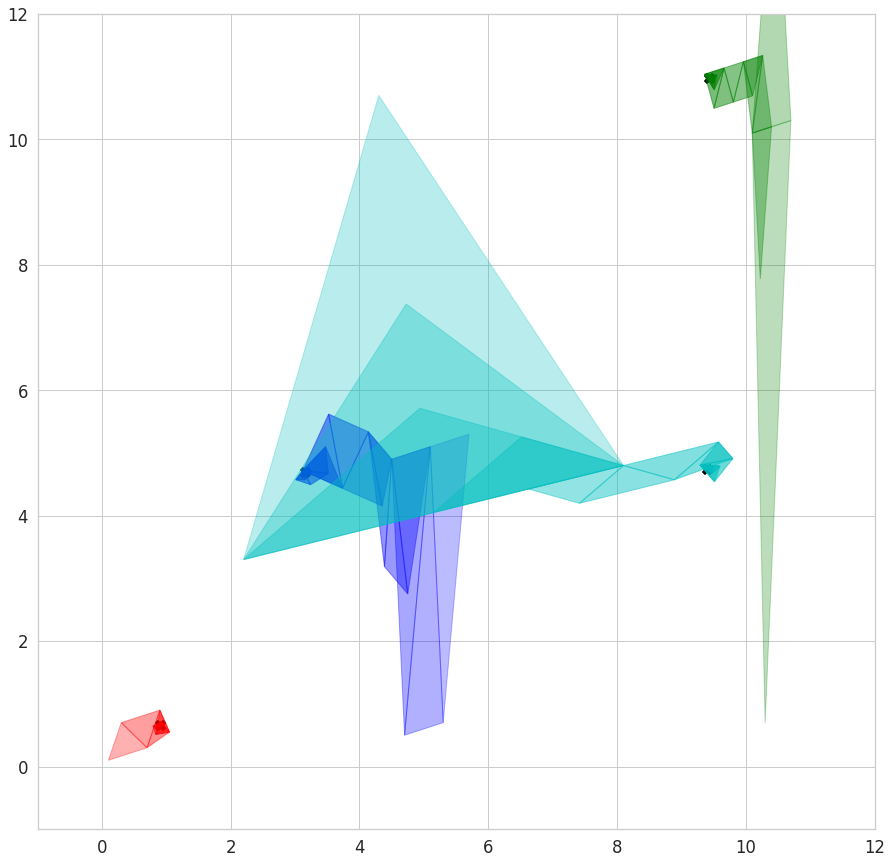

In [59]:
fig, ax = plt.subplots(figsize=(15, 15))

alpha_start = 0.2
alpha_exp = 0.7

ax.scatter(results[:, 0], results[:, 1], s=100, color='black', alpha=1, marker='X')

for sequence, color in zip(sequences, ['r', 'g', 'b', 'c']):
    cmap = get_cmap(sequence.shape[0])
    for i, triangle in enumerate(sequence):
        alpha = ((i+1) / sequence.shape[0])**alpha_exp
        alpha = alpha_start + (1 - alpha_start) * alpha
        ax.fill(triangle[:, 0], triangle[:, 1], color=color, alpha=alpha, edgecolor=color)

ax.set_xlim(-1, 12)
ax.set_ylim(-1, 12)
plt.show()

Попытался изобразить, как будут сходиться треугольнички к нужному значению. Как можно увидеть, с разными стартовыми точками сходимся к разным значениям. Объясняется это тем, что задача у нас не является выпуклой, как уже было сказано, имеется большое число экстремумов, в т.ч. минимумов

### 3. Сходимость при разных гиперпараметрах

На графике 1 значения лежат на отрезке длины 0.000145 по x и 0.000355 по y
На графике 2 значения лежат на отрезке длины 0.004435 по x и 0.001882 по y


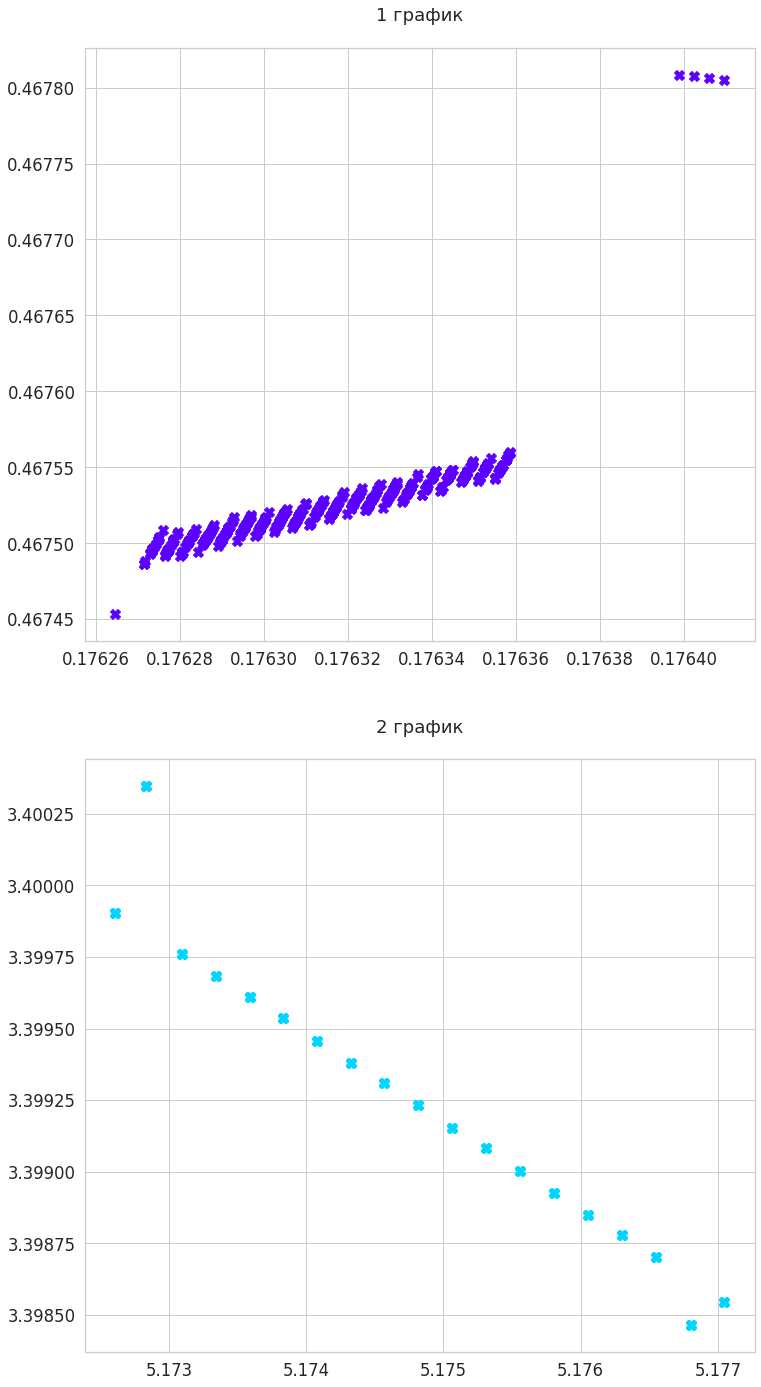

In [61]:
n = 20
alphas = np.linspace(0.01, 100, n)
betas = np.linspace(0.01, 0.99, n)
gammas = np.linspace(0.01, 0.99, n)

starts = np.array([[(0.1, 0.1), (2.3, 10.7), (10.7, 2.3)],
                   [(5.1, 5.1), (5.3, 0.7), (5.7, 5.3)]])

alphas, betas, gammas = np.meshgrid(alphas, betas, gammas)
alphas = alphas.ravel()
betas = betas.ravel()
gammas = gammas.ravel()

fig, axs = plt.subplots(2, figsize=(12, 24))

cmap = get_cmap(100)
for i in range(starts.shape[0]):
    start = starts[i]
    results, sequences = zip(*[NelderMead(f, start, alpha=a, beta=b, gamma=g, eps=1e-9) if g > a else ([np.nan, np.nan], []) for a, b, g in zip(alphas, betas, gammas)])
    results = np.array(results)
    results = results[~np.isnan(results).any(axis=1)]
    ax = axs[i]
    lims = (results.max(axis=0) - results.min(axis=0))
    print(f"На графике {i+1} значения лежат на отрезке длины {lims[0]:.6f} по x и {lims[1]:.6f} по y")
    ax.scatter(results[:, 0], results[:, 1], s=100, color=cmap(np.random.randint(0, 100)), alpha=1, marker='X')
    ax.set_title(f"{i + 1} график\n")

plt.show()

Получаются вот такие веселые графики. Заметим, что есть еще несколько случаев, когда получаются похожие графики, но размер отрезков по x и y, на которых получаются ответы, достаточно малы, т.е. это вопрос точности. Однако, конкретно в этих двух случаях расстояние между точками (а точнее, np.std для них и значений функций) будут недостаточны, чтобы объяснить такое поведение точностью - растояние между точками в некоторых местах порядка 5e-4, а между самыми далекими около 4e-3 - для ни стандартное отклонение будет сильно больше $\epsilon = 10^{-9}$

In [67]:
# Берем точки примерно такие же, как на графике 3
check = np.array([[5.173, 3.40], [5.175, 3.39925], [5.177, 3.9985]])
std_f = np.std(f(check))
std_x = ((check - check.mean(axis=0))**2).mean()

print(f'Стандартное отклонение по значениям функции: {std_f:0.3f}, по исходным точкам: {std_x:0.3f}')

Стандартное отклонение по значениям функции: 2.446, по исходным точкам: 0.040


Т.е. условно таким образом показали, что если бы 3 точки из представленных выше на графике 3, были бы получены в какой-то момент при вычислении, то на этом алгоритм не закончился бы, т.к отклонение слишком велико, т.е. не выполняется условие остановки. На графике 1 вообще виден "анклав" из нескольких точек, которые далеко находятся от основной массы

Таким образом разные гиперпараметры привели к разным ответам

(Выгружаю в html, можно не смотреть

In [69]:
from google.colab import drive 
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [70]:
%ls
%cd 'gdrive/MyDrive/mipt-opt'
%ls

gdrive/  sample_data/
/content/gdrive/MyDrive/mipt-opt
mipt-opt-hw6.ipynb  Seminar6_fivt.ipynb


In [71]:
%%shell
jupyter nbconvert --to html mipt-opt-hw6.ipynb

[NbConvertApp] Converting notebook mipt-opt-hw6.ipynb to html
[NbConvertApp] Writing 978545 bytes to mipt-opt-hw6.html
